In [9]:
import yahoo_fin
from yahoo_fin.stock_info import get_data
# import requests_html
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
%matplotlib inline

In [10]:
import sys
print(sys.version)

3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

C:\Users\Linus\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [4]:
start = '01/01/2022'
#end = '09/22/2022'
today = date.today()
end = today.strftime("%m/%d/%y")

def stock_data(x, start, end):
    df = get_data(x, start_date = start, end_date = end, index_as_date = True, interval = '1d')
    df.reset_index(inplace = True)
    df = df.rename(columns={df.columns[0]:'date'})
    df = df[['date','close','volume']]
    return df

def VWMA(stock, period):
    df = stock_data(str(stock), start, end)
    temp = df['close'] * df['volume']
    VWMA = [None] * (period - 1)
    accumulator = sum(temp[:period])
    VWMA.append(accumulator / sum(df['volume'][:period]))
    
    for i in range(len(temp) - period):
        accumulator -= temp[i]
        accumulator += temp[i+period]
        VWMA.append(accumulator / sum(df['volume'][i+1:i+1+period]))
    
    return VWMA
    

VWMA('9618.HK', 10)





[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 274.4040455848424,
 274.88086285164627,
 275.56859748453047,
 280.99069301420536,
 287.48216853082937,
 292.0487933787309,
 293.0618073878638,
 293.3532449258622,
 290.32297127198404,
 288.31598846746635,
 285.49473946159475,
 285.5654458156658,
 285.87849472988165,
 286.96802142733935,
 284.5511865217159,
 282.58158386526196,
 283.1303067220602,
 284.41039605621586,
 284.7216518108118,
 286.6219525919022,
 292.37060953939977,
 292.5692142889998,
 293.2857763769607,
 292.1653748638544,
 289.96503529591035,
 288.3277514620829,
 283.7748134746547,
 282.0564440447581,
 281.1503545622204,
 281.5387232599863,
 281.00194952424175,
 280.9000371569709,
 276.70061590165,
 270.6807149594874,
 264.72317839954786,
 259.9342698191652,
 256.9007734739734,
 246.73397036577688,
 231.14344788191107,
 217.24736124748236,
 215.8168027489145,
 219.8547942908153,
 218.56951943921652,
 217.58237213263874,
 218.85448090834922,
 219.5489295352207

,date,close,VWMA1,VWMA2
24,2022-02-09,298.000000,282.581584,281.185216
25,2022-02-10,301.799988,283.130307,281.819802
26,2022-02-11,298.600006,284.410396,282.477448
27,2022-02-14,289.600006,284.721652,285.260632
28,2022-02-15,290.399994,286.621953,287.312380
...,...,...,...,...
493,2024-01-08,101.199997,107.354963,104.416018
494,2024-01-09,98.000000,106.305813,104.042678
495,2024-01-10,98.199997,105.834534,103.826916
496,2024-01-11,99.900002,105.166387,103.728395


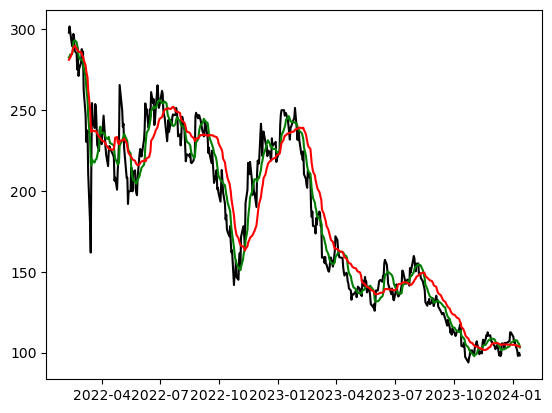

In [5]:
def visualise(stock, period1, period2):
    df = stock_data(stock, start, end)[['date','close']]
    temp1 = VWMA(stock, period1)
    temp2 = VWMA(stock, period2)
    df['VWMA1'] = temp1
    df['VWMA2'] = temp2
    df.dropna(inplace = True)
    
    plt.plot(df['date'], df['close'], color = 'black')
    plt.plot(df['date'], df['VWMA1'], color = 'green')
    plt.plot(df['date'], df['VWMA2'], color = 'red')
    
    return df
visualise('9618.HK', 10, 25)

In [6]:
def trade_rule_1(stock, start, end):
    df = stock_data(stock, start, end)[['date','close']]
    temp1 = VWMA(stock, 10)
    temp2 = VWMA(stock, 25)
    df['VWMA1'] = temp1
    df['VWMA2'] = temp2
    df.dropna(inplace = True)
    df['trade'] = np.nan
    
    for i in range(1,len(df)):
        if (df['close'].iloc[i] > df['VWMA2'].iloc[i]) & (df['VWMA1'].iloc[i] > df['VWMA2'].iloc[i]) & (df['VWMA1'].iloc[i-1] < df['VWMA2'].iloc[i-1]):
            df.iloc[i,4] = "Y"
        elif (df['close'].iloc[i] < df['VWMA1'].iloc[i]) & (df['close'].iloc[i-1] > df['VWMA1'].iloc[i-1]):
            df.iloc[i,4] = "N"
    df.dropna(inplace = True)
    df['temp_shift'] = df['trade'].shift(1)  # create a shifted column
    df = df[df['trade'] != df['temp_shift']]  # keep only the rows where the current and previous values differ
    df = df.drop(columns=['temp_shift']) 
    
    cum_return = 0
    
    df['return'] = np.nan
    df.reset_index(inplace = True)
    del df['index']
    
    for i in range(1, len(df), 2):
        df['return'].iloc[i] = (df['close'].iloc[i] - df['close'].iloc[i-1])
        
    return df
(trade_rule_1("9618.HK", start, end))
#trade_rule_1("9618.HK", start, end).iloc[0]

C:\Users\Linus\AppData\Local\Temp\ipykernel_6608\2919127655.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'].iloc[i] = (df['close'].iloc[i] - df['close'].iloc[i-1])


,date,close,VWMA1,VWMA2,trade,return
0,2022-02-16,297.200012,292.370610,288.648123,Y,NaN
1,2022-02-18,287.000000,293.285776,289.914322,N,-10.200012
2,2022-03-29,238.399994,236.938179,233.185549,Y,NaN
3,2022-03-30,238.000000,239.834867,232.771605,N,-0.399994
4,2022-05-04,239.600006,232.505145,231.297821,Y,NaN
5,2022-05-06,226.600006,235.268515,232.424964,N,-13.000000
6,2022-06-07,238.800003,219.461867,219.334738,Y,NaN
7,2022-06-22,240.800003,251.386001,234.918770,N,2.000000
8,2022-08-30,247.000000,234.245391,232.570511,Y,NaN
9,2022-09-05,236.800003,241.866888,234.678918,N,-10.199997


In [7]:
np.sum(trade_rule_1("9618.HK", start, end)['return'])

C:\Users\Linus\AppData\Local\Temp\ipykernel_6608\2919127655.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'].iloc[i] = (df['close'].iloc[i] - df['close'].iloc[i-1])


-5.5